# Diffusion of innovations in small-world networks with reflexivity

This code uses the diffusion of innovations model present in

> *Diffusion dynamics in small-world networks with heterogeneous consumers* from Delre, Sebastiano A., Jager, Wander and Janssen, Marco A., Computational and Mathematical Organization Theory, **13**, 2, 2007.

with some modifications. It also uses new features that try to introduce reflexivity in that model.

In [2]:
# Necessary libraries

from __future__ import division

# Stdlin imports
import random

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

In [453]:
plt.style.use('seaborn-paper')

## 1. Auxiliary functions

### 1.1 For plots

In [4]:
def set_colors(graph):
    """
    Create a list of colors to apply to graph
    
    Adopters are blue and non-adopters are red
    """
    colors = []
    for n in graph.nodes():
        node = G.node[n]
        if node['adopter'] == 1:
            colors.append('b')
        else:
            colors.append('r')
    
    return colors

In [6]:
def draw_graph(graph, node_positions):
    """Function to draw the graph in which the evolution is occurring"""
    nx.draw_networkx_nodes(graph, node_positions, node_color=set_colors(graph), node_size=50)
    nx.draw_networkx_edges(graph, node_positions, width=0.3, alpha=0.5)

In [7]:
def animate(i, graph, node_positions, parameters, test=False):
    """Function to animate the algorithm evolution"""
    #print(i)
    if test:
        node = graph.node[i]
        node['adopter'] = 1
    else:
        evolution_step(graph, parameters)
    draw_graph(graph, node_positions)

### 1.2 For the algorithm

In [3]:
def get_neighbors(graph, node, level):
    """Get neighbors of a given node up to a certain level"""
    min_level = int(level)
    if min_level < level:
        max_level = min_level + 1
        percentaje = level - min_level
    else:
        max_level = level
        percentaje = 0
    
    # All neighbors up to max_level
    all_neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=max_level)
    
    if percentaje > 0:
        neighbors_min_level = [k for (k, v) in all_neighbors.items() if (1 <= v <= min_level)]
        neighbors_max_level = [k for (k, v) in all_neighbors.items() if v == max_level]
        n = np.round(len(neighbors_max_level) * percentaje)
        additional_neighbors = random.sample(neighbors_max_level, int(n))
        neighbors = neighbors_min_level + additional_neighbors
    else:
        neighbors = [k for (k, v) in all_neighbors.items() if (1 <= v <= max_level)]
    
    return neighbors

In [5]:
def is_adopter(graph, node):
    """Return True if a node is an adopter"""
    return graph.node[node]['adopter'] == 1

In [406]:
def get_adopters(graph):
    """Get the nodes that are adopters in the graph"""
    return [x for x in graph.nodes() if is_adopter(graph, x)]

In [8]:
def speed_of_diffusion(adopters):
    """
    Compute the velocity of diffusion $rho$
    
    This is done according to equation 6 in the article
    """
    T = len(adopters)
    cumulative_adopters = np.cumsum(adopters)
    return (1/T) * ( sum(cumulative_adopters) / sum(adopters) )

In [91]:
def homophily_index(graph):
    """
    Return the number of cross-gender edges over the total number of edges
    
    Cross-gender edges mean edges between adopters and non-adopters
    """
    cross_gender_edges = []
    for e in graph.edges():
        i = e[0]
        j = e[1]
        if is_adopter(graph, i) and not is_adopter(graph, j) or is_adopter(graph, j) and not is_adopter(graph, i):
            cross_gender_edges.append(e)
    
    #print( len(cross_gender_edges), len(graph.edges()) )
    return len(cross_gender_edges) / len(graph.edges())

In [381]:
def clustering_index(graph):
    """
    Return an index that quantifies how big the size of adopter
    clusters is in the entire population of consumers
    
    This index computes the cluster-size-weighted average of adopter
    clusters divided by the total number of consumers
    
    So it goes from 0 to 1 and it's always increasing.
    """
    N = len(graph.nodes())
    adopters = get_adopters(graph)
    
    clusters = nx.subgraph(graph, adopters)
    cluster_sizes = [len(c) for c in nx.connected_components(clusters) if len(c) > 1]
    if cluster_sizes:
        # The weight of each cluster depends on its size
        weights = np.array(cluster_sizes) / N
        # Compute the weighted average
        weigthed_average = np.average(cluster_sizes, weights=weights)
        # Since the index needs to go between 0 and 1, we need to divide between N
        # again
        index = weigthed_average / N
        return index
    else:
        return 0

In [ ]:
def logistic(x, k, x0):
    """
    Logistic function
    
    See https://en.wikipedia.org/wiki/Logistic_function for
    its parameters
    """
    if x == 0:
        return 0
    elif x == 1:
        return 1
    else:
        return 1 / ( 1 + np.exp(-k * (x - x0)) )

In [740]:
def step(x, k, x0):
    """
    Step function
    
    Taken from http://stackoverflow.com/a/28892278/438386
    
    k is not needed but it's added here to have the same interface as
    the logistic function above
    """
    return 1. * (x > x0)

## Algorithm

In [9]:
def generate_initial_conditions(number_of_nodes, parameters):
    """
    Initial conditions for the simulation
    
    Create the graph on which the diffusion occurs and set additional
    attributes for its node
    
     `parameters` is a dictionary that contains the parameters that control
     the evolution.
    """
    # Network creation.
    # 4 is the average number of neighbors each node has in the graph
    # This number is fixed in the article
    G = nx.generators.watts_strogatz_graph(number_of_nodes, 4,
                                           parameters['randomness'])
    
    for node_index in G.nodes():
        node = G.node[node_index]
        node['adopter'] = 0                              # 1 is adopter, 0 non-adopter
        node['preference'] = np.random.random()          # pi
        #node['minimal_utility'] = np.random.random()
        
        # Neighbors never change if the level is an int
        if int(parameters['level']) - parameters['level'] == 0:
            node['neighbors'] = get_neighbors(G, node_index, parameters['level'])
        else:
            node['neighbors'] = []
    
    # Create a seed of initial adopters if there's no marketing
    if not parameters['marketing_effort']:
        seed = np.round(len(G.nodes()) * parameters['initial_seed'])
        initial_adopters = random.sample(G.nodes(), int(seed))
        
        for node_index in initial_adopters:
            node = G.node[node_index]
            node['adopter'] = 1
    
    return G

In [55]:
def evolution_step(graph, parameters, test=False):
    """
    Function that computes the evolution step of the diffusion process
    that occurs in a small-world graph
    
    `parameters` is a dictionary that contains the parameters that
    control the evolution.
    """
    
    #minimal_utility = parameters['minimal_utility']
    
    # Adopters before performing the current step
    previous_adopters = get_adopters(graph)
    
    # To save the adopters at this time step
    adopters_at_step = []
    
    # Compute quantities that depend on the global state of the system.
    # Thus they are the same for all agents during this time step
    if parameters['reflexivity']:
        # Compute utility due to indirect social influence
        indirect_utility = clustering_index(graph)

        # Decide which activation function to use.
        if not test:
            activation = logistic
        else:
            activation = step
        
        # Compute reflexivity index
        reflexivity_index = activation(indirect_utility,
                                       parameters['reflexivity_coefficient'],
                                       parameters['reflexivity_threshold'])
        #print(reflexivity_index)
    
    
    # Determine which agents adopt
    for node_index in graph.nodes():
        node = graph.node[node_index]

        # -- Adoption due to marketing
        if parameters['marketing_effort']:
            p = np.random.random()
            if not node['adopter'] and (p < parameters['marketing_effort']):
                adopters_at_step.append(node_index)
                continue

        # -- Compute utility due to direct social influence
        # Adopters
        if node['neighbors']:
            neighbors = node['neighbors']
        else:
            neighbors = get_neighbors(graph, node_index, level=parameters['level'])
        adopters_among_neighbors = [x for x in neighbors if is_adopter(graph, x)]

        # Only if a consumer has adopters among his neighbors, he computes
        # his direct utility
        if len(adopters_among_neighbors) > 0:

            # Ai value
            adopters_percentaje = len(adopters_among_neighbors) / len(neighbors)

            # Computing xi
            if adopters_percentaje > parameters['social_threshold']:
                local_influence = 1
            else:
                local_influence = 0
            
            # Set individual preference (yi)
            if parameters['quality'] >= node['preference']:
                individual_preference = 1
            else:
                individual_preference = 0

            # Computing utility Ui
            direct_utility = parameters['social_influence'] * local_influence + \
                             (1 - parameters['social_influence']) * individual_preference
        else:
            direct_utility = 0
        
        # -- Compute utility if reflexivity is on or off
        if parameters['reflexivity']:
            # Compute utility if agent has become aware of a global pattern
            # or not
            alpha = np.random.random()
            if alpha < reflexivity_index:
                utility = direct_utility + indirect_utility - direct_utility * indirect_utility
            else:
                utility = direct_utility
        else:
            utility = direct_utility
        
        # Decide to adopt if agent's utility is higher than a minimal
        # utility
        minimal_utility = np.random.random()
        if minimal_utility <= utility:
            adopters_at_step.append(node_index)
        
        # print(utility)
        #if utility > node['minimal_utility']: #minimal_utility:
        #    if np.random.random() > node['minimal_utility']:
        #        node['adopter'] = 1
    
    # Update the graph with customers who adopted in this time step
    for node_index in adopters_at_step:
        node = graph.node[node_index]
        node['adopter'] = 1
    
    # Return number of adopters at time t
    current_adopters = get_adopters(graph)
    return len(current_adopters) - len(previous_adopters)

In [17]:
def evolution(graph, parameters, max_time='complete_adoption', compute_index=False, test=False):
    """Compute the evolution of the algorithm up to max_time"""
    # Save the adopters at each time during the evolution
    adopters = []
    
    # Compute the aggregation index during the evolution
    if compute_index:
        indexes = []
    
    # Perform the evolution
    if max_time == 'complete_adoption':
        while not all( [is_adopter(graph, x) for x in graph.nodes()] ):
            adopters_at_t = evolution_step(graph, parameters, test)
            adopters.append(adopters_at_t)
            if compute_index:
                indexes.append(clustering_index(graph))
    else:
        for t in range(max_time):
            adopters_at_t = evolution_step(graph, parameters, test)
            adopters.append(adopters_at_t)
    
    if compute_index:
        return indexes
    else:
        return adopters

In [12]:
def compute_run(number_of_times, max_time, number_of_nodes, parameters):
    """
    Compute a run of the algorithm
    
    A run consists in repeating the evolution of the algorithm under
    the same conditions a certain number_of_times
    """
    # Print the parameters of the run
    print(parameters)

    # Perform the run
    speeds = []
    for i in range(number_of_times):
        graph = generate_initial_conditions(number_of_nodes, parameters)
        adopters = evolution(graph, parameters, max_time)
        speed = speed_of_diffusion(adopters)
        speeds.append(speed)
    
    #return [np.mean(speeds), np.std(speeds)]
    return np.mean(speeds)

## Running the algorithm

These are main parameters that control the evolution of the algorithm, and their corresponding variable in the article:

* Network randomness (`randomness`): $r$
* Quality: $q_{j}$
* Marketing effort: $e_{1}$
* Social influence: $\beta_{j}$
* Social threshold: $h_{i}$
* Level: $L$
* Reflexivity threshold: $r_{0}$
* Reflexivity coefficient: $k$

In [721]:
parameters = dict(
    randomness = 0.001,
    quality = 0.5,
    marketing_effort = 0.0001,
    social_influence = 0.6,
    social_threshold = 0.3,
    #minimal_utility = 0.5,
    level = 2,
    reflexivity_coefficient = 35,
    reflexivity_threshold = 0.85,
    initial_seed = 0.01
)

In [ ]:
beta_speeds = {}
for beta in [0.6, 0.8, 1]:
    speeds = []
    parameters['social_influence'] = beta
    for r in [0.0001, 0.001, 0.01, 0.1, 1]:
        parameters['randomness'] = r
        speed = compute_run(number_of_times=20,
                            max_time=250,
                            number_of_nodes=1000,
                            parameters=parameters)
        print(speed)
        speeds.append(speed)
    #print(speeds)
    beta_speeds[beta] = speeds

## Plots

### 2d plots

In [14]:
%matplotlib inline

In [716]:
G = generate_initial_conditions(1000, parameters)

In [717]:
# Perform the evolution of a single realization until there is
# complete adoption
parameters['reflexivity'] = False
print(parameters)
adopters_no_rx = evolution(G, parameters)

{'social_influence': 0.6, 'randomness': 0.001, 'level': 2, 'reflexivity_coefficient': 14, 'social_threshold': 0.3, 'reflexivity': False, 'reflexivity_threshold': 0.7, 'quality': 0.5, 'marketing_effort': 0.0001}


In [718]:
parameters['reflexivity'] = True
print(parameters)
for i in G.nodes():
    G.node[i]['adopter'] = 0
adopters_rx = evolution(G, parameters)

{'social_influence': 0.6, 'randomness': 0.001, 'level': 2, 'reflexivity_coefficient': 14, 'social_threshold': 0.3, 'reflexivity': True, 'reflexivity_threshold': 0.7, 'quality': 0.5, 'marketing_effort': 0.0001}


In [ ]:
# Plot adopters at each time
plt.plot(adopters_no_rx, label='Without Reflexivity')
plt.plot(adopters_rx, label='With Reflexivity')
plt.legend()

In [ ]:
# Plot the cumulative sum of adopters and non-adopters (the usual diffusion curve)
plt.plot(np.cumsum(adopters_no_rx), label='Without Reflexivity')
plt.plot(np.cumsum(adopters_rx), label='With Reflexivity')
plt.legend()

In [ ]:
plt.plot(np.cumsum(adopters_rx), label='With Reflexivity')

In [ ]:
# Perform the evolution of a single realization until there is
# complete adoption
print(parameters)
G = generate_initial_conditions(10000, parameters)
indexes = evolution(G, parameters, compute_index=True)

In [ ]:
plt.plot(indexes)

### Logistic function form

This explores how the logistic function changes under different values of $k$ and $x_{0}$

In [324]:
from sympy import plot, symbols, exp

In [322]:
x = symbols('x')

In [722]:
def symbolic_logistic(x, k, x0):
    return 1 / ( 1 + exp(-k * (x - x0)) )

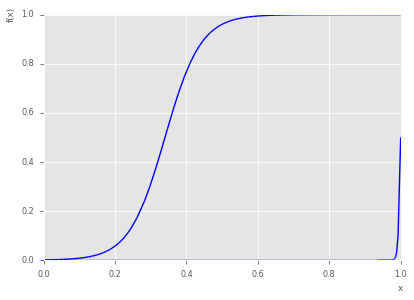

In [723]:
plot(symbolic_logistic(x, 300, 1), symbolic_logistic(x, 20, 0.34), (x, 0, 1))

In [725]:
symbolic_logistic(0.99, 300, 1)

0.0474258731775667

### Animations

In [ ]:
%matplolib qt

In [ ]:
G = generate_initial_conditions(1000, parameters)

In [ ]:
# Plot an animation of the evolution
fig = plt.figure()
positions = nx.spring_layout(G)
animation.FuncAnimation(fig, lambda i: animate(i, G, positions, parameters, test=False),
                        frames=500, interval=3, repeat=False)